<a href="https://colab.research.google.com/github/Vaibhav67979/Ecommerce-product-recommendation-system/blob/main/ECommerce_Product_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sistema de recomendación de productos de comercio electrónico

##Importar librerías

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds # para matrices dispersas

## Importar conjunto de datos

In [ ]:
#Importar el conjunto de datos
df = pd.read_csv(r'ratings_Electronics.csv', header=None) #No hay encabezados en el archivo de datos

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Agregando nombres de columnas

df = df.drop('timestamp', axis=1) #Eliminando marca de tiempo

df_copy = df.copy(deep=True) #Copiar los datos a otro dataframe

## EDA - Análisis Exploratorio de Datos

Verificar:
- forma
- tipo de dato
- valores faltantes


Finalmente obtener el resumen y verificar:
- distribución de calificaciones.
- número de usuarios y productos.
- Usuarios con el mayor número de calificaciones.

### Forma

In [ ]:
rows, columns = df.shape
print("Número de filas = ", rows)
print("Número de columnas = ", columns)

No of rows =  7824482
No of columns =  3


### Tipos de datos

In [6]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  str    
 1   prod_id  str    
 2   rating   float64
dtypes: float64(1), str(2)
memory usage: 179.1 MB


### Análisis de valores faltantes

In [ ]:
# Encontrar el número de valores faltantes en cada columna
df.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

### Resumen

In [ ]:
# Estadísticas resumidas de la variable 'rating'
df['rating'].describe()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

### Distribución de calificaciones

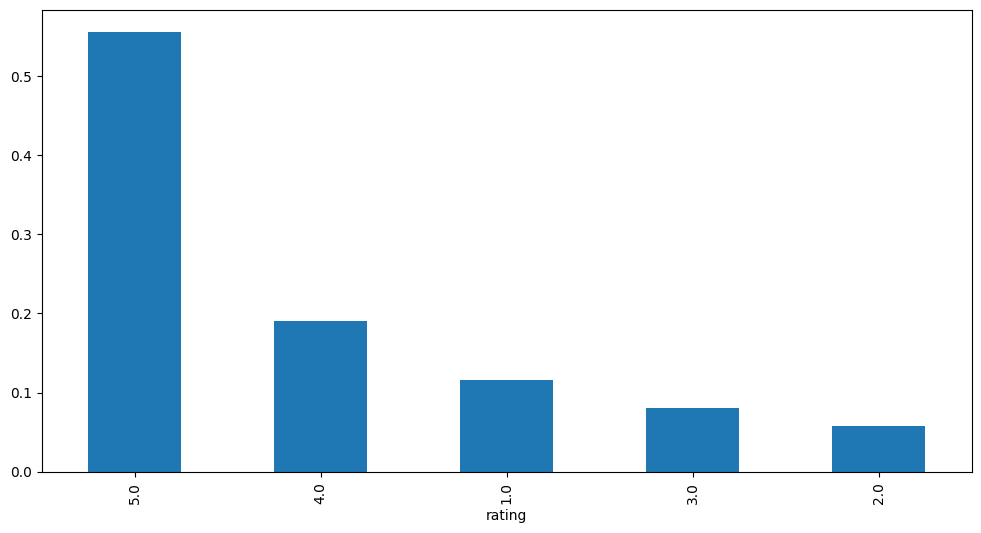

In [ ]:
#Crear el gráfico y proporcionar observaciones

plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

La distribución está sesgada hacia la derecha. Más del 50% de las calificaciones son 5, seguido de poco menos del 20% con calificaciones de 4 estrellas. Y los porcentajes de calificaciones siguen bajando hasta que menos del 10% de las calificaciones son de 2 estrellas.

### Número de usuarios y elementos únicos

In [ ]:
# Número de ID de usuario e ID de producto únicos en los datos
print('Número de USUARIOS únicos en datos sin procesar = ', df['user_id'].nunique())
print('Número de ARTÍCULOS únicos en datos sin procesar = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique ITEMS in Raw data =  476002


### Usuarios con mayor número de calificaciones

In [ ]:
# Top 10 usuarios por calificaciones
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

## Pre-procesamiento

Tomemos un subconjunto del conjunto de datos (manteniendo solo a los usuarios que han dado 50 o más calificaciones) para hacer que el conjunto de datos sea menos disperso y fácil de trabajar.

In [12]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [ ]:
print('El número de observaciones en los datos finales =', len(df_final))
print('Número de USUARIOS únicos en los datos finales = ', df_final['user_id'].nunique())
print('Número de PRODUCTOS únicos en los datos finales = ', df_final['prod_id'].nunique())

The number of observations in the final data = 125871
Number of unique USERS in the final data =  1540
Number of unique PRODUCTS in the final data =  48190


- El dataframe **df_final tiene usuarios que han calificado 50 o más artículos**
- **Usaremos df_final para construir sistemas de recomendación**

### Verificar la densidad de la matriz de calificaciones

In [ ]:
#Crear la matriz de interacción de productos y usuarios basada en calificaciones y reemplazar valores NaN con 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Forma de final_ratings_matrix: ', final_ratings_matrix.shape)

#Encontrar el número de entradas distintas de cero en la matriz de interacción 
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Encontrar el número posible de calificaciones según el número de usuarios y productos
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Densidad de calificaciones
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('densidad: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Sistema de Recomendación Basado en Clasificación

In [ ]:
#Calcular la calificación promedio para cada producto 
average_rating = df_final.groupby("prod_id")['rating'].mean()

#Calcular el número de calificaciones para cada producto
count_rating = df_final.groupby('prod_id')['rating'].count()

#Crear un dataframe con el promedio calculado y el número de calificaciones
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

#Ordenar el dataframe por promedio de calificaciones
final_rating = final_rating.sort_values(by='avg_rating',ascending=False)

final_rating.head()

,avg_rating,rating_count
prod_id,,
1400699169,5.0,1
B00LKG1MC8,5.0,1
0594451647,5.0,1
1685560148,5.0,1
B00LGQ6HL8,5.0,5


In [ ]:
#definiendo una función para obtener los n productos principales según la calificación promedio más alta e interacciones mínimas
def top_n_products(final_rating, n, min_interaction):
    
    #Encontrar productos con el número mínimo de interacciones
    recommendations = final_rating[final_rating['rating_count']>min_interaction]
    
    #Ordenar valores respecto a la calificación promedio 
    recommendations = recommendations.sort_values('avg_rating',ascending=False)
    
    return recommendations.index[:n]

## Recomendando los 5 productos principales con 50 interacciones mínimas basado en popularidad

In [20]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

## Recomendando los 5 productos principales con 100 interacciones mínimas basado en popularidad

In [21]:
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

# Sistema de Recomendación Basado en Filtrado Colaborativo

## Filtrado colaborativo basado en el usuario

In [22]:
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Aquí, user_id (índice) es del tipo de dato objeto. Reemplazaremos el user_id por números comenzando desde 0 hasta 1539 (para todos los IDs de usuario) para que el índice sea de tipo entero y represente un ID de usuario en el mismo formato

In [ ]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Calificaciones reales dadas por los usuarios
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Función para encontrar usuarios similares y sus puntuaciones de similitud

In [ ]:
# definiendo una función para obtener usuarios similares
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]): #  .shape[0] da el número de filas
        
        #encontrar la similitud del coseno entre el user_id y cada usuario
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])
        
        #Agregando el usuario y la puntuación de similitud correspondiente con user_id como tupla
        similarity.append((user,sim))
        
    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extraer el usuario de cada tupla en la lista ordenada
    similarity_score = [tup[1] for tup in similarity] ##Extrayendo la puntuación de similitud de cada tupla en la lista ordenada
   
    #Eliminar el usuario original y su puntuación de similitud y mantener solo otros usuarios similares 
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])
       
    return most_similar_users, similarity_score

#### Encontrando los 10 usuarios similares principales al índice de usuario 3 y sus puntuaciones de similitud

In [27]:
similar = similar_users(3,final_ratings_matrix)[0][0:10]
similar

[320, 12, 793, 261, 156, 1493, 1250, 567, 753, 1360]

In [ ]:
#Imprimir la puntuación de similitud
similar_users(3,final_ratings_matrix)[1][0:10]

[array([[0.05662371]]),
 array([[0.05549645]]),
 array([[0.05098326]]),
 array([[0.05024185]]),
 array([[0.05003874]]),
 array([[0.04930111]]),
 array([[0.04889354]]),
 array([[0.04672744]]),
 array([[0.04637283]]),
 array([[0.04492668]])]

#### Encontrando los 10 usuarios similares principales al índice de usuario 1521 y sus puntuaciones de similitud

In [ ]:
similar = similar_users(1521, final_ratings_matrix)[0][0:10]
similar

[991, 1065, 1012, 1402, 1371, 1278, 1518, 692, 785, 161]

In [ ]:
#Imprimir la puntuación de similitud
similar_users(1521,final_ratings_matrix)[1][0:10]

[array([[0.10889304]]),
 array([[0.10538068]]),
 array([[0.1026758]]),
 array([[0.09418291]]),
 array([[0.09149062]]),
 array([[0.09135361]]),
 array([[0.09028898]]),
 array([[0.08735684]]),
 array([[0.08673386]]),
 array([[0.08478815]])]

### Función para recomendar productos

In [ ]:
# definiendo la función de recomendaciones para obtener recomendaciones utilizando las preferencias de usuarios similares
def recommendations(user_index, num_of_products, interactions_matrix):
    
    #Guardando usuarios similares usando la función similar_users definida arriba
    most_similar_users = similar_users(user_index, interactions_matrix)[0]
    
    #Encontrar IDs de producto con los que el user_id ha interactuado
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []
    
    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:
            
            #Encontrar 'n' productos que han sido calificados por usuarios similares pero no por el user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break
    
    return recommendations[:num_of_products]

#### Recomendar 5 productos al índice de usuario 3 basado en filtrado colaborativo basado en similitud

In [ ]:
recommendations(3,5,final_ratings_matrix)

['B001TAAVP4', 'B0016E5X5Q', 'B0054U6CEE', 'B00006IW1X', 'B000HWVOFQ']

#### Recomendar 5 productos al índice de usuario 1521 basado en filtrado colaborativo basado en similitud

In [ ]:
recommendations(1521,5,final_ratings_matrix)

['B007X3VEUW', 'B005TDWUII', 'B0040XQ7PK', 'B009O7XGCY', 'B00A7PPLP2']

# Filtrado Colaborativo Basado en Modelos: Descomposición de Valores Singulares 

**Hemos visto arriba que la matriz de interacción es altamente dispersa. SVD es mejor para aplicar en una matriz dispersa grande. Tenga en cuenta que para matrices dispersas, podemos usar la función sparse.linalg.svds() para realizar la descomposición**

Además, usaremos **k=50 características latentes** para predecir la calificación de productos

## Matriz CSR

In [ ]:
from scipy.sparse import csr_matrix
final_ratings_sparse = csr_matrix(final_ratings_matrix.values)


## SVD

In [ ]:
# Descomposición de Valores Singulares
U, s, Vt = svds(final_ratings_sparse, k = 50) # aquí k es el número de características latentes

# Construir matriz diagonal en SVD
sigma = np.diag(s)

In [ ]:
U.shape

(1540, 50)

In [ ]:
sigma.shape

(50, 50)

In [ ]:
Vt.shape

(50, 48190)

Ahora, regeneremos la matriz original usando matrices U, Sigma y Vt. La matriz resultante sería las calificaciones predichas para todos los usuarios y productos

## Prediciendo calificaciones

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Calificaciones predichas
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_df.head()
preds_matrix = csr_matrix(preds_df.values)

## Función para recomendar productos

In [ ]:
import numpy as np

def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):
    
    # Obtener las calificaciones del usuario de las matrices de interacción reales y predichas
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creando un dataframe con columnas de calificaciones reales y predichas
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')
    
    #Filtrando el dataframe donde las calificaciones reales son 0 lo que implica que el usuario no ha interactuado con ese producto
    temp = temp.loc[temp.user_ratings == 0]   
    
    #Recomendando productos con calificaciones predichas principales
    temp = temp.sort_values('user_predictions',ascending=False)#Ordenar el dataframe por user_predictions en orden descendente
    print('\nA continuación se encuentran los productos recomendados para el usuario(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))

### Recomendando los 5 productos principales al ID de usuario 121

In [ ]:
#Ingresar 'índice de usuario' y 'num_recomendaciones' para el usuario
recommend_items(121,final_ratings_sparse,preds_matrix,5)


Below are the recommended products for user(user_id = 121):

Recommended Products
28761    2.414390
39003    1.521306
41420    1.309224
40158    1.200111
33819    1.126866
Name: user_predictions, dtype: float64


### Recomendando los 10 productos principales al ID de usuario 100

In [ ]:
recommend_items(100,final_ratings_sparse,preds_matrix,10)


Below are the recommended products for user(user_id = 100):

Recommended Products
11078    1.624746
16159    1.132730
10276    1.047888
22210    0.955049
18887    0.879705
41618    0.854430
45008    0.816153
43419    0.803755
28761    0.748799
14791    0.748797
Name: user_predictions, dtype: float64


## Evaluando el modelo

In [ ]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

prod_id
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [ ]:
preds_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,0.061477,0.001214,0.123433,0.028490,0.016109,0.002855,0.174568,0.011367,0.012997
1,0.002286,0.010898,0.000724,0.130259,0.007506,0.003350,0.063711,0.000674,0.016111,0.002433,...,0.000038,0.013766,0.001473,0.025588,0.042103,0.004251,0.002177,0.024362,0.014765,0.038570
2,0.001655,0.002675,0.007355,0.007264,0.005152,0.003986,0.003480,0.006961,0.006606,0.002719,...,0.001708,0.051040,0.000325,0.054867,0.017870,0.004996,0.002426,0.083928,0.112205,0.005964
3,0.001856,0.011019,0.005910,0.014134,0.000179,0.001877,0.005391,0.001709,0.004968,0.001402,...,0.000582,0.009326,0.000465,0.048315,0.023302,0.006790,0.003380,0.005460,0.015263,0.025996
4,0.001115,0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,0.019347,0.012749,0.001026,0.001364,0.020580,0.011828,0.012770


In [ ]:
avg_preds=preds_df.mean()
avg_preds.head()

prod_id
0594451647    0.003360
0594481813    0.005729
0970407998    0.008566
0972683275    0.035330
1400501466    0.006966
dtype: float64

In [ ]:
rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()

,Avg_actual_ratings,Avg_predicted_ratings
prod_id,,
0594451647,0.003247,0.003360
0594481813,0.001948,0.005729
0970407998,0.003247,0.008566
0972683275,0.012338,0.035330
1400501466,0.012987,0.006966


In [ ]:
RMSE=mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'], squared=False)
print(f'RMSE SVD Model = {RMSE} \n')

RMSE SVD Model = 0.013679389779858 

